### Sanity checks on the topic modelling project for DM dataset : High Sensory (HS) condition


Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 31/07/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [1]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText
!pip install llama-cpp-python
!{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

from grid_search_colyra import *
from META_helpers_colyra import split_sentences,reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')


condition = "HS" 
sentences = True
random_seed = 22
nr_topics = None 



results_GS = pd.read_csv(f'/home/romy/lyra/RESULTSentences/grid_search_results_{condition}_seed22.csv')

reports_path = os.path.join("DATA2",f"{condition}_reflections.csv")
df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


if sentences:
    df_reports = split_sentences(df_reports)


In [2]:
#only print the results that have between 10 and 25 number of topics
# results_GS = results_GS[results_GS['n_topics']<=20]
# results_GS = results_GS[results_GS['n_topics']>=10]
# results_GS = results_GS.sort_values(by='coherence_score',ascending=False)


#only print results that have a coherence score u_mass that is not empty
results_GS = results_GS[results_GS['cohenrece_score_umass'].notnull()]

results_GS.head(5)


n_components  n_neighbors  min_dist  min_cluster_size  min_samples  \
2             9           10       0.0                10            6   
4             7           20       0.0                 6           13   
5             9           10       0.0                 6            6   
6             7           10       0.0                 6           13   
9             9           15       0.0                10           13   

   coherence_score  cohenrece_score_umass  n_topics  \
2         0.562414              -8.175496        17   
4         0.543942              -7.609188        10   
5         0.543306              -9.567279        22   
6         0.532852              -7.393436        10   
9         0.522061              -7.397412         8   

                                               model  
2  BERTopic(calculate_probabilities=True, ctfidf_...  
4  BERTopic(calculate_probabilities=True, ctfidf_...  
5  BERTopic(calculate_probabilities=True, ctfidf_...  
6  BERTopic(calculate_probabilities=True, ctfidf_...  
9  BERTopic(calculate_probabilities=True, ctfidf_...

In [3]:
chosen_params = results_GS.iloc[0]
chosen_params


n_components                                                             9
n_neighbors                                                             10
min_dist                                                               0.0
min_cluster_size                                                        10
min_samples                                                              6
coherence_score                                                   0.562414
cohenrece_score_umass                                            -8.175496
n_topics                                                                17
model                    BERTopic(calculate_probabilities=True, ctfidf_...
Name: 2, dtype: object

In [4]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')))#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams



n_neighbors = chosen_params['n_neighbors']
n_components = chosen_params['n_components']
min_dist = chosen_params['min_dist']
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 5



metric='cosine'

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [5]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [6]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='english',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score,coherence_score_umass = calculate_coherence(model, df_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['colors', 'shapes', 'patterns', 'saw', 'like'], ['peace', 'calm', 'sense', 'joy', 'relaxation'], ['felt', 'like', 'space', 'felt like', 'flying'], ['felt', 'relaxed', 'experience', 'felt relaxed', 'safe'], ['experience', 'overall', 'good', 'interesting', 'amazing experience'], ['music', 'sound', 'patterns', 'pattern', 'wanted'], ['vision', 'eyes', 'front', 'flashing', 'sometimes'], ['thought', 'mind', 'aware', 'started', 'thinking'], ['would', 'could', 'time brief', 'perhaps take', 'wish could'], ['stars', 'saw', 'moving like', 'planets', 'saw stars'], ['wanting', 'go', 'experience', 'wanted', 'feeling'], ['dreaming', 'asleep', 'deepest', 'awake', 'put'], ['drugs', 'lsd', 'acid', 'like acid', 'dmt'], ['memories', 'beautiful', 'back', 'anymore', 'patchwork quilt'], ['death', 'life', 'rebirth', 'death rebirth', 'die'], ['colors', 'many', 'within', 'brain', 'intense colors']]
Coherence Score: 0.562414484705358
n = 17 topics extracted


In [7]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [8]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

In [9]:
from torch import bfloat16
import transformers

# Quantization to load an LLM with less GPU memory
# process reduces the 64-bit representation to only 4-bits which reduces the GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

access_token = os.getenv('ACCESS_TOKEN')

model_id = 'meta-llama/Llama-2-13b-chat-hf'

# Llama 2 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id,use_auth_token=access_token)

# Llama 2 Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=access_token
)
model.eval()



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [11]:
#(eg do not include ANYTHING such as 'Based on the information provided, a suitable scientific label for this topic could be:")
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)



# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics from open reports.
<</SYS>>
"""


example_prompt = """
The task is the following :  Based on the information about the topic above, please suggest a short label for this topic. Make sure to ONLY return the label and nothing more.
[/INST]
"""




#Template for topic labelling to use within BERTopic ==> our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please suggest a scientific label for this topic. Make sure you to ONLY return the label and nothing more (eg do not include ANYTHING such as 'Based on the information provided, a suitable scientific label for this topic could be:").}
[/INST]
"""


prompt = system_prompt + example_prompt + main_prompt




embeddings.shape

(691, 768)

In [12]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.8)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)


# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr
}

In [13]:
import torch
torch.cuda.empty_cache()

In [14]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,

  nr_topics = nr_topics,

  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)


100%|██████████| 17/17 [00:11<00:00,  1.45it/s]


In [15]:
#extract all llama2 labels
llama2_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
print(llama2_labels)

# filter out unlabelled topics for ddatamap visu
llm_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics

#filter out unlabelled topics for other visus
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

[' SENSORY EXPERIENCE', ' Visual Perception of Geometric Patterns and Colors', ' Emotional State - Relaxation', ' Space-related altered state experience', ' Emotional Experience', ' Positive Experience', ' Multisensory Experience', ' Visual Perception and Pattern Recognition', ' Cognitive Processes', ' Sensory Deprivation and Meditation', ' Astrophysical Phenomena', ' Emotional Intensity', 'Hypnagogic State', ' Psychedelic Substances - DMT and LSD', ' Childhood Memories', ' Death and Rebirth Experience', ' Visual Hallucinations']


{0: ' Visual Perception of Geometric Patterns and Colors',
 1: ' Emotional State - Relaxation',
 2: ' Space-related altered state experience',
 3: ' Emotional Experience',
 4: ' Positive Experience',
 5: ' Multisensory Experience',
 6: ' Visual Perception and Pattern Recognition',
 7: ' Cognitive Processes',
 8: ' Sensory Deprivation and Meditation',
 9: ' Astrophysical Phenomena',
 10: ' Emotional Intensity',
 11: 'Hypnagogic State',
 12: ' Psychedelic Substances - DMT and LSD',
 13: ' Childhood Memories',
 14: ' Death and Rebirth Experience',
 15: ' Visual Hallucinations'}

In [16]:
hierarchy_vis = topic_model.visualize_hierarchy(title=f"Hierarchical clustering ({condition},Llama2)",custom_labels=True, color_threshold=1)
hierarchy_vis

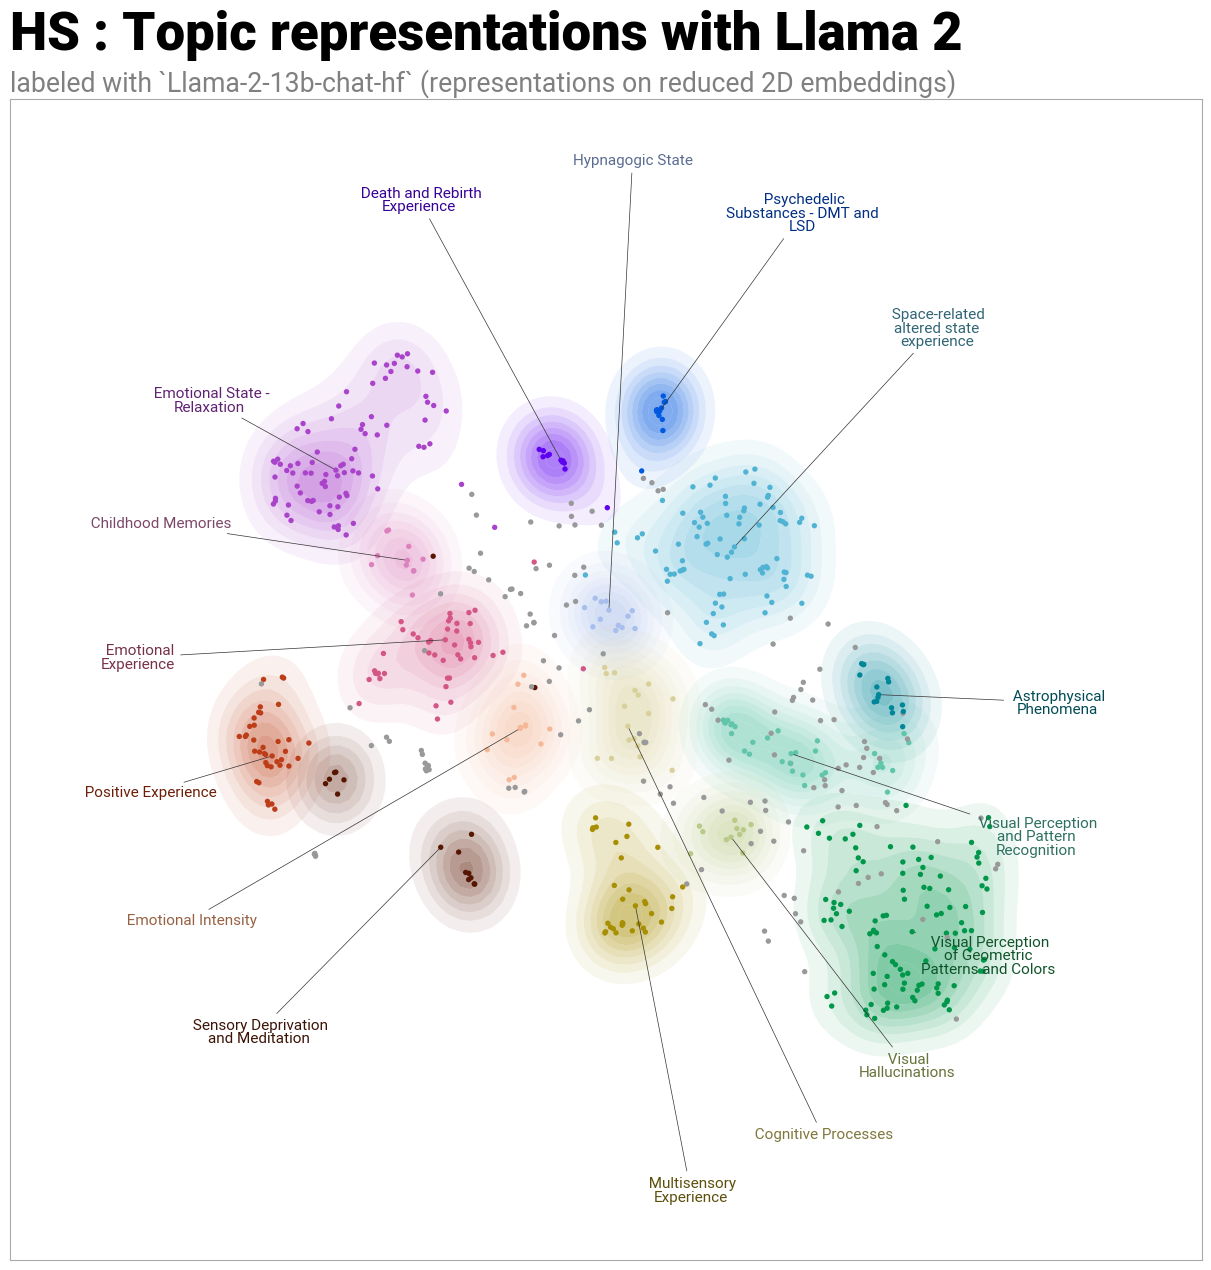

In [17]:
import datamapplot
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title=f"{condition} : Topic representations with Llama 2",
   sub_title="labeled with `Llama-2-13b-chat-hf` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [18]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 2)",
hide_annotations=False, hide_document_hover=False, custom_labels=True)

# LLAMA 3

In [19]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

In [20]:
# # GPU-accelerated HDBSCAN + UMAP
# !pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

In [21]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
# from cuml.manifold import UMAP  # For UMAP dimensionality reduction
# from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [22]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [23]:
prompt = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the information about the topic above, please create a short, concise label for this topic, that is very comprehensive for all the sentences that are contained in this topic. Make sure you to only return the label and nothing more.Do not include any extra sentences or explanations.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


In [24]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  nr_topics = nr_topics,

  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)

# Show topics
topic_model.get_topic_info()

100%|██████████| 17/17 [00:48<00:00,  2.82s/it]


Topic  Count                                   Name  \
0      -1    142                       -1_the_in_and_of   
1       0    108                 0_and_colors_of_shapes   
2       1     85                 1_peace_calm_sense_and   
3       2     85                 2_felt_was_the_through   
4       3     46                    3_felt_was_and_very   
5       4     38  4_experience_overall_good_interesting   
6       5     33                  5_music_the_and_sound   
7       6     32                   6_my_vision_the_eyes   
8       7     17                  7_my_thought_how_mind   
9       8     17                 8_do_would_could_again   
10      9     16               9_stars_saw_planets_like   
11     10     14                   10_to_it_him_wanting   
12     11     13       11_dreaming_asleep_deepest_awake   
13     12     12                    12_drugs_on_dmt_lsd   
14     13     11          13_memories_my_beautiful_them   
15     14     11              14_death_you_life_rebirth   
16     15     11                 15_colors_of_were_many   

                                       Representation  \
0        [the, in, and, of, to, it, was, my, me, saw]   
1   [and, colors, of, shapes, patterns, saw, like,...   
2   [peace, calm, sense, and, joy, relaxation, jou...   
3   [felt, was, the, through, like, space, in, of,...   
4   [felt, was, and, very, it, relaxed, the, exper...   
5   [experience, overall, good, interesting, it, a...   
6   [music, the, and, sound, it, to, patterns, on,...   
7   [my, vision, the, eyes, front, of, to, flashin...   
8   [my, thought, how, mind, aware, and, about, th...   
9   [do, would, could, again, the, it, to, meditat...   
10  [stars, saw, planets, like, large, everything,...   
11  [to, it, him, wanting, go, wanted, again, expe...   
12  [dreaming, asleep, deepest, awake, put, had, w...   
13  [drugs, on, dmt, lsd, acid, closest, psychedel...   
14  [memories, my, beautiful, them, back, emotive,...   
15  [death, you, life, rebirth, die, like, what, s...   
16  [colors, of, were, many, within, art, brain, s...   

                                              KeyBERT  \
0   [felt, sensation, pulsating, scary, kaleidosco...   
1   [kaleidoscopes, kaleidoscope, kaleidoscopic, c...   
2   [peacefulness, tranquility, peace, happiness, ...   
3   [felt, feel, flying, universe, space, experien...   
4   [relaxed, comforted, felt, euphoria, comfort, ...   
5   [enjoyable, experience, experienced, lovely, v...   
6   [music, rhythms, rhythm, sensory, sound, liste...   
7   [vision, eyes, felt, eye, focused, brightness,...   
8   [consciousness, subconscious, imagery, concent...   
9   [meditative, mindfulness, breathing, massage, ...   
10  [stars, kaleidoscope, light, planets, eruption...   
11  [felt, feeling, feel, unnerving, emotions, ove...   
12  [wakefulness, dreaming, dreams, dreamingly, dr...   
13  [psychedelics, hallucinogens, psychedelic, lsd...   
14  [memories, childhood, memory, felt, remembered...   
15  [souls, death, rebirth, soul, life, die, dead,...   
16  [hallucinations, visuals, colors, art, creativ...   

                                                  LLM  \
0   ["Vivid Visual Meditation with Sensual Underto...   
1   ["Vibrant Geometric Patterns with Kaleidoscope...   
2   ["A Journey of Inner Peace and Relaxation"  | ...   
3   [Spiritual Cosmic Journey Experience\n```pytho...   
4       ["Peak Experiential Bliss", , , , , , , , , ]   
5   ["Summary of Positive Life Experiences", , , ,...   
6   [Multisensory Music Experience with Symbolic S...   
7   ["Visual phenomena experienced during meditati...   
8   [Mind-wandering during visual experience., , ,...   
9   [Meditative Experience Improvements Suggestion...   
10  ["Stellar visual experience with shifting colo...   
11  [Emotional Experiences and Control of Inner St...   
12  [Dream-state ambiguity and its manifestation d...   
13  ["Personal Experiences with Psychedelics: Self...   
14  ["Childhood Memories with Fa

In [25]:
# Create a label for each document
llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

{0: 'Vibrant Geometric Patterns with Kaleidoscope Colors and Shapes ',
 1: 'A Journey of Inner Peace and Relaxation label',
 2: 'Spiritual Cosmic Journey Experience',
 3: 'Peak Experiential Bliss',
 4: 'Summary of Positive Life Experiences',
 5: 'Multisensory Music Experience with Symbolic Significance',
 6: 'Visual phenomena experienced during meditation ',
 7: 'Mind wandering during visual experience ',
 8: 'Meditative Experience Improvements Suggestions',
 9: 'Stellar visual experience with shifting colors and celestial bodies 0 10',
 10: 'Emotional Experiences and Control of Inner States',
 11: 'Dream state ambiguity and its manifestation during sleep wake transitions ',
 12: 'Personal Experiences with Psychedelics Self Experimentation and Seeking',
 13: 'Childhood Memories with Family',
 14: 'Reflections on Mortality and Existence',
 15: 'Multidimensional Color Experience'}

In [26]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

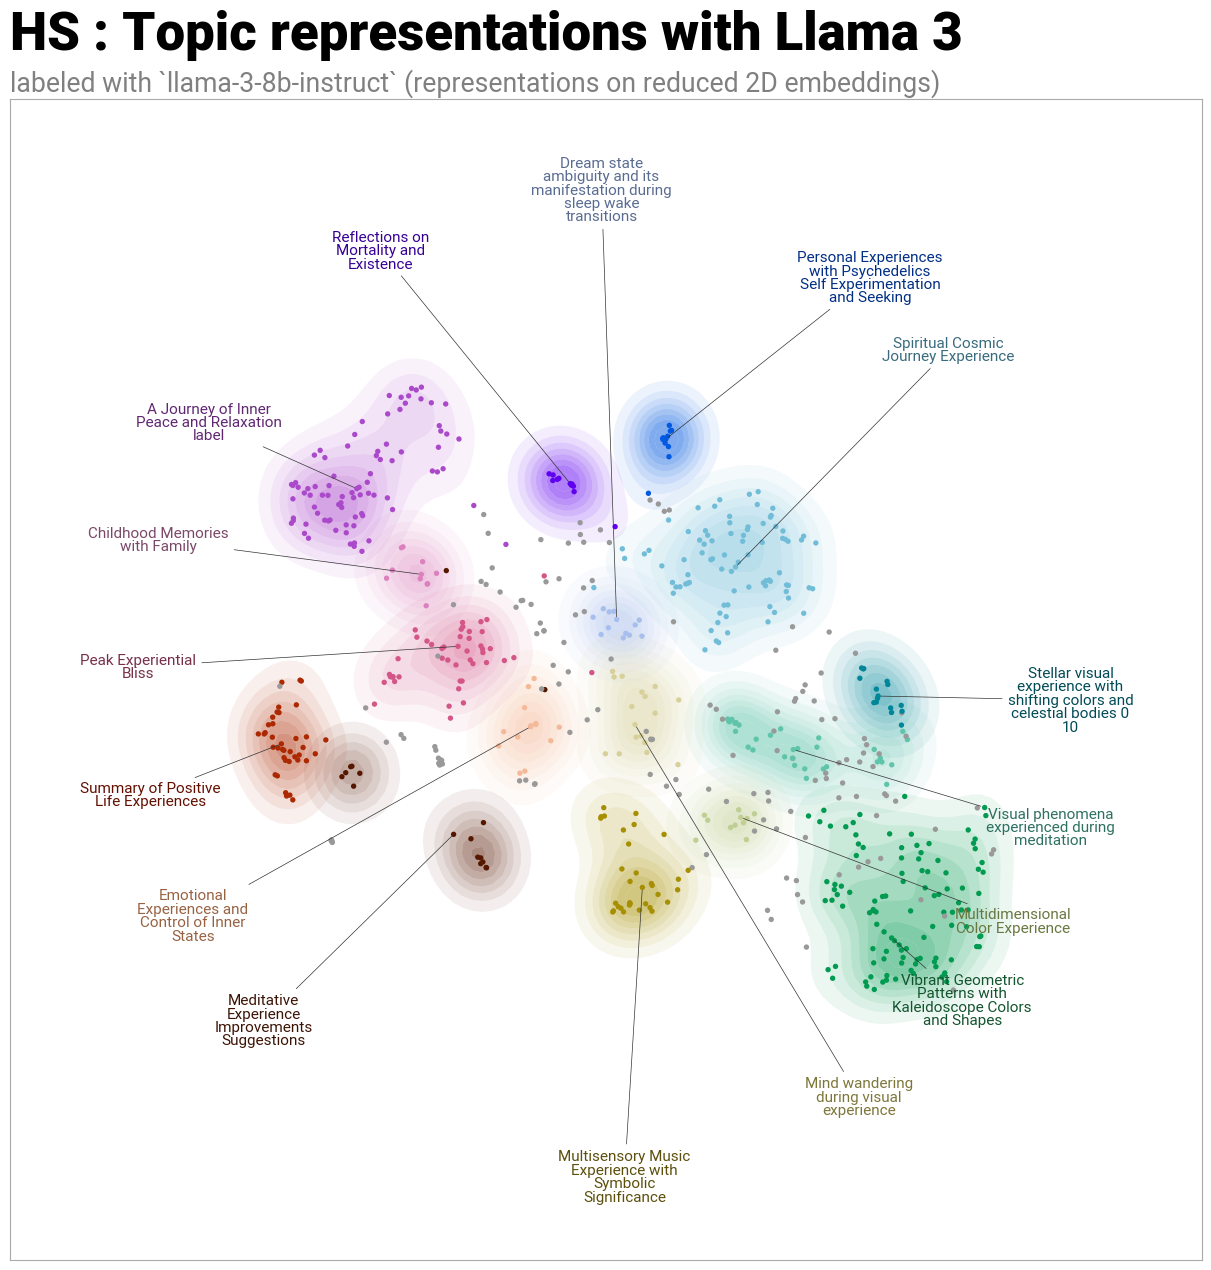

In [27]:
# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title=f"{condition} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [28]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.8)
hierarchy_vis